# Data Augmentation for ResNet18

In [1]:
import lightning as L
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from lightning.pytorch.loggers import CSVLogger
import matplotlib.pyplot as plt
import numpy as np

from shared_utilities import LightningModel, Cifar10DataModule, plot_loss_and_acc

In [2]:
entrypoints = torch.hub.list('pytorch/vision', force_reload=True)
for e in entrypoints:
    if "resnet" in e:
        print(e)

Downloading: "https://github.com/pytorch/vision/zipball/main" to /home/borja-dosuna/.cache/torch/hub/main.zip
deeplabv3_resnet101
deeplabv3_resnet50
fcn_resnet101
fcn_resnet50
resnet101
resnet152
resnet18
resnet34
resnet50
wide_resnet101_2
wide_resnet50_2


In [3]:
pytorch_model = torch.hub.load('pytorch/vision', 'resnet18', weights=None)

Using cache found in /home/borja-dosuna/.cache/torch/hub/pytorch_vision_main


In [4]:
L.pytorch.seed_everything(123)
dm = Cifar10DataModule(batch_size=64)
dm.prepare_data()
dm.setup()

Seed set to 123


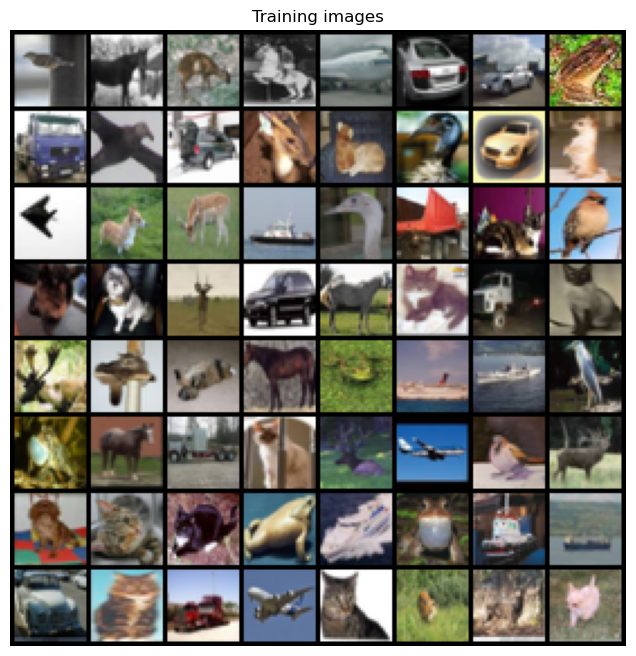

In [5]:
for images, labels in dm.train_dataloader():  
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64], 
    padding=2,
    normalize=True),
    (1, 2, 0)))
plt.show()

## Custom Data Transform

In [6]:
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torch.utils.data.dataset import random_split

class Cifar10DataModule(L.LightningDataModule):
    def __init__(self, data_path="./", batch_size=64, num_workers=0,
                 train_transform=None, test_transform=None):
        super().__init__()
        self.batch_size = batch_size
        self.data_path = data_path
        self.num_workers = num_workers
        self.train_transform = train_transform
        self.test_transform = test_transform

    def prepare_data(self):
        datasets.CIFAR10(root=self.data_path, download=True)
        return

    def setup(self, stage=None):
        train = datasets.CIFAR10(
            root=self.data_path,
            train=True,
            transform=self.train_transform,
            download=False,
        )

        self.test = datasets.CIFAR10(
            root=self.data_path,
            train=False,
            transform=self.test_transform,
            download=False,
        )

        self.train, self.valid = random_split(train, lengths=[45000, 5000])

    def train_dataloader(self):
        train_dataloader = DataLoader(
            dataset=self.train,
            batch_size=self.batch_size,
            drop_last=True,
            shuffle=True,
            num_workers=self.num_workers,
        )
        return train_dataloader

    def val_dataloader(self):
        val_dataloader = DataLoader(
            dataset=self.valid,
            batch_size=self.batch_size,
            drop_last=False,
            shuffle=False,
            num_workers=self.num_workers,
        )
        return val_dataloader

    def test_dataloader(self):
        test_dataloader = DataLoader(
            dataset=self.test,
            batch_size=self.batch_size,
            drop_last=False,
            shuffle=False,
            num_workers=self.num_workers,
        )
        return test_dataloader

In [7]:
from torchvision import transforms

train_transform = transforms.Compose(
    [
        transforms.Resize((150, 150)),
        transforms.RandomCrop((128, 128)),
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # [0, 1] -> [-1, 1]
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((150, 150)),
        transforms.CenterCrop((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)       

## Model

In [8]:
%%capture --no-display

L.seed_everything(123)
# Use a bigger batch_size if you want full GPU VRAM utilization. With my settings, batch_size=1024 produces 10603MiB /  12227MiB 
dm = Cifar10DataModule(batch_size=64, num_workers=4, train_transform=train_transform,
                       test_transform=test_transform)
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.1)

trainer = L.Trainer(
    max_epochs=50,
    accelerator="gpu",
    devices=1,
    logger=CSVLogger(save_dir="logs/", name="my-model"),
    deterministic=True,
)

Seed set to 123
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


In [9]:
trainer.fit(model=lightning_model, datamodule=dm)

You are using a CUDA device ('NVIDIA GeForce RTX 5070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ ResNet             │ 11.7 M │ train │     0 │
│ 1 │ train_acc │ MulticlassAccuracy │      0 │ train │     0 │
│ 2 │ val_acc   │ MulticlassAccuracy │      0 │ train │     0 │
│ 3 │ test_acc  │ MulticlassAccuracy │      0 │ train │     0 │
└───┴───────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 11.7 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 11.7 M                                                                                               
Total estimated model params size (MB): 46                                                                         
Modules in train mode: 71                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=50` reached.


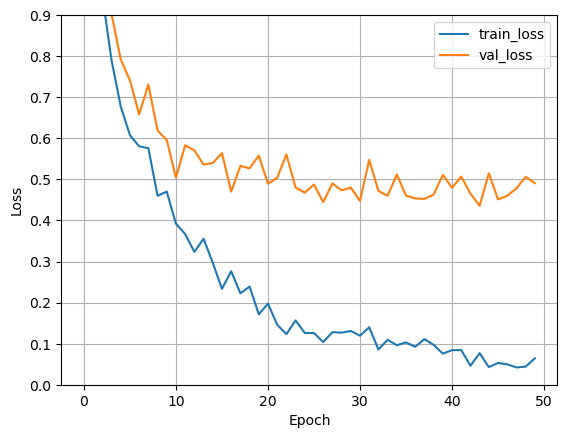

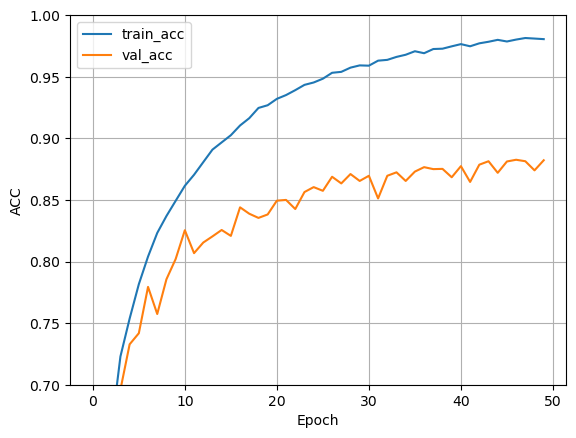

In [10]:
plot_loss_and_acc(trainer.logger.log_dir)

In [11]:
trainer.test(model=lightning_model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8931999802589417     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8931999802589417}]